In [ ]:
import os
os.environ["MKL_NUM_THREADS"]="16" 
os.environ["NUMEXPR_NUM_THREADS"]='16'
os.environ["OMP_NUM_THREADS"]='16'
import matplotlib.pyplot as plt
import types
import numpy as np
from tqdm import notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim
from sklearn.decomposition import FastICA, PCA

%matplotlib inline

from importlib import reload
import torchvision

import Generators, Features, Data, Likelihoods

import KernelWakeSleep as kws

device = torch.device("cuda:0")
reload(Data)

In [2]:
batch_size = 100
dname = "van"
binary= False and dname == "mnist"
nc = 3 if dname == "cifar" else 1


nsleep = 2000
nepoch = 20
nvalid = 200


_, natural_images = Data.load_data(dname, binary=binary, ntrain=10**5, ntest=10**4, image_size=16, 
                                           batch_size=batch_size)
Dx = natural_images.shape[-1]
image_size = int(np.sqrt(Dx//nc))

15.69891


In [3]:
ica = FastICA(n_components=36, max_iter=1000)
ica.fit(natural_images)
A = torch.tensor(ica.mixing_, dtype=torch.float, device=device)
# A -= A.mean(dim=0)
A /= A.norm(dim=0)

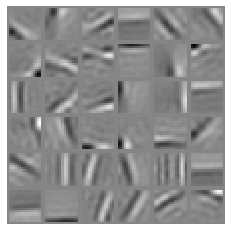

In [4]:
from scipy.stats import norm
from itertools import product

pad = 1

# x = vae_means[:nz*nz]
nz=int(np.sqrt(A.shape[-1]))
x = A.cpu().numpy().T
# x -= x.mean(-1, keepdims=True)
# x /= x.std(-1, keepdims=True)
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))

x = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0) ))
x = x.reshape(nz,nz,image_size+2*pad,image_size+2*pad,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
plt.figure(figsize=(4,4))

if nc == 1:
    x = x[...,0]


plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()

In [5]:
reload(Generators)
reload(Features)
reload(Likelihoods)
reload(kws)

<module 'KernelWakeSleep' from '/nfs/ghome/live/kevinli/Code/kws/KernelWakeSleep.py'>

In [6]:
D0 = A.shape[1]
log_noise = torch.zeros((), requires_grad=True, device=device)
# log_noise = torch.tensor(np.log(0.1), requires_grad=True, device=device)

if dname == "van":
    tanh = sigmoid = False
else:
    tanh = not binary
    sigmoid = binary
    
# generative model
nl = torch.nn.Identity()
prior = torch.distributions.Laplace(torch.zeros(D0, device=device), torch.ones(D0,device=device))
gen_network = Generators.lin_gen(D0, Dx, nl=nl).to(device)

gen_network.apply(kws.weights_init)

if not binary:
    obs   = Likelihoods.GaussianObservation(gen_network, log_noise)
else:
    obs   = Likelihoods.BernoulliObservation(gen_network)

In [7]:
ntrain = 100000

train_images = nl(prior.sample([ntrain]) @ A.to(device).T * 1 )

ntest = 10000
test_images  = nl(prior.sample([ntest])  @ A.to(device).T * 1 )

def pre_process(data):
    data = data - data.mean(0, keepdims=True)
    clear_data = data / data.std(0, keepdims=True)
    data = clear_data + torch.randn(*clear_data.shape, device=device) * 0.1

    return clear_data, data
clear_train_images, train_images = pre_process(train_images)
clear_test_images, test_images = pre_process(test_images)

In [8]:
kwargs = {'num_workers': 4, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_images)),
    batch_size=batch_size, shuffle=True)


/nfs/ghome/live/kevinli/anaconda3/envs/alws/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


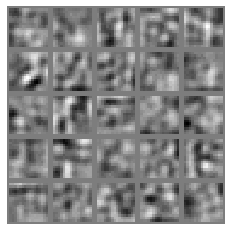

In [9]:
from scipy.stats import norm
from itertools import product

pad = 1
nz=5
x = train_images[:nz*nz]

x = x.cpu().numpy()
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))

x = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0) ))
x = x.reshape(nz,nz,image_size+2*pad,image_size+2*pad,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
plt.figure(figsize=(4,4))

if nc == 1:
    x = x[...,0]


plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()

In [10]:
nnet = 3
block_size=100

data = kws.draw_sample(prior, obs, nsleep)

kernel_networks = []
Fdata = []
for i in range(nnet):
    k = Features.lin_feat(Dx, block_size, bn=False).to(device)
#     k = torch.nn.Identity().to(device)
#     k = Features.dc_feat(image_size,ngf, nfinal=100, bn=False, nl=True, nc=nc).to(device)
    k.apply(kws.weights_init)
    Fdata += k(data),
    kernel_networks += k,
    
Fdata   = torch.cat(Fdata, -1) 
Fmedian =  kws.estimate_median_distance(Fdata)
kernel = kws.Kernel(kernel_networks, Fmedian, lam=1e-3, train_sigma=False, train_lam=False).to(device)

In [11]:
optimizer = optim.Adam(list(gen_network.parameters())+[log_noise], lr=0.001)
kernel_optimizer = optim.Adam([kernel.log_sigma,kernel.log_lam], lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
network_grad_norms = []

feat_mmds = []
recons = []

In [ ]:
nsleep = 2000

gen_network.train()
kernel.train()

for ei in notebook.tqdm(range(1000)):
    
    with notebook.tqdm(train_loader, leave=False) as t:
        for i, (X_tr,) in enumerate(t):
        
            X_tr = X_tr.float().to(device)

            data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
            data_0_val, data_1_val, norm_val, nat_val = kws.sleep(prior, obs, nsleep, detach=True)
            S_val = obs.suff(data_1_val)
            
            if i % 1 == 0 :
                kernel_optimizer.zero_grad()
                Elogp_val = kws.KRR_2(obs.suff, kernel, data_1_val, data_1, norm, nat)

                loss_val = torch.mean((Elogp_val + norm_val - (nat_val * S_val).sum(-1))**2)

#                 kernel_network_norm = sum([sum(
#                                             map(lambda x: (x**2).sum(), k.parameters())
#                                                 )
#                                            for k in kernel_networks])        
#                 kernel_network_norms += kernel_network_norm.cpu().detach().numpy(),

                loss_val = loss_val
                loss_val.backward(retain_graph=False)
    
                
                kernel_optimizer.step()
                log_lams += kernel.log_lam.cpu().detach().numpy(),
                log_sigmas += kernel.log_sigma.cpu().detach().numpy(),
                losses += loss_val.detach().cpu().numpy(),
                    
            data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
            
            Elogp  = kws.KRR_2(obs.suff, kernel, X_tr, data_1, norm, nat).mean()   
            
            gen_loss = -Elogp
            
            
            t.set_postfix(Elogp=Elogp.item(), std=obs.log_std.exp().item(), sigma=kernel.log_sigma.exp().item())

            Elogps += Elogp.detach().cpu().numpy(),

            optimizer.zero_grad()
            gen_loss.backward(retain_graph=False)
                        
            network_norm = sum(map(lambda x: (x**2).sum(), gen_network.parameters()))
            network_norms += network_norm,
            network_grad_norm = sum(map(lambda x: (x.grad**2).sum(), gen_network.parameters()))
            network_grad_norms += network_grad_norm,

            optimizer.step()

            if not binary:
                noise_stds += obs.log_std.exp().detach().cpu().numpy(),

In [13]:
torch.cuda.empty_cache()

In [ ]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          kernel_network_norms, noise_stds]

nplot = len(params)
fig, axes = plt.subplots(3,nplot//3+1, figsize=(15,12), sharex=False)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)

# axes[0].set_xlim([20000,2000])

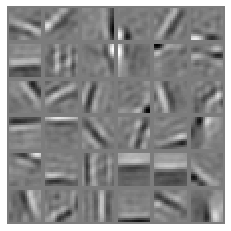

In [27]:
from scipy.stats import norm
from itertools import product

pad = 1

# x = vae_means[:nz*nz]
nz=int(np.sqrt(D0))
x = obs.network[1].weight.detach().cpu().numpy()[:,:nz*nz].T
# x = np.load("results/ica/ica_36_16_o0_minibatch.npz")["A_est"].T
# x -= x.mean(-1, keepdims=True)
# x /= x.std(-1, keepdims=True)
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))

x = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0) ))
x = x.reshape(nz,nz,image_size+2*pad,image_size+2*pad,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
plt.figure(figsize=(4,4))

if nc == 1:
    x = x[...,0]


plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()

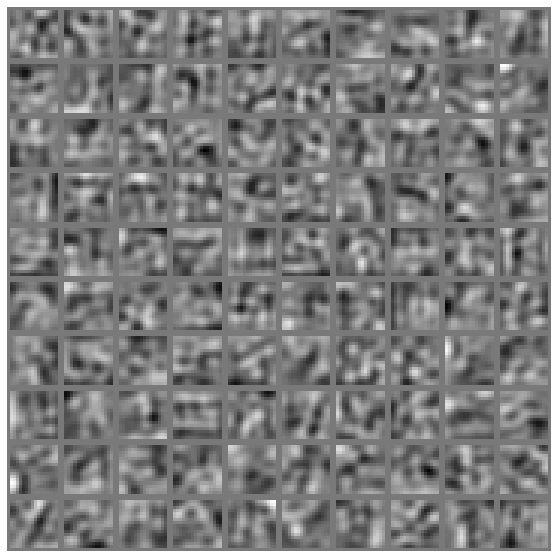

In [31]:
from scipy.stats import norm
from itertools import product

pad = 1

# x = vae_means[:nz*nz]
nz=int(np.sqrt(D0))
nz = 10
x = kws.draw_mean(prior,obs, nz*nz).cpu().numpy()
# x = clear_test_images[:nz*nz].cpu().numpy()
x -= x.mean(-1, keepdims=True)
x /= x.std(-1, keepdims=True)
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))

x = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0) ))
x = x.reshape(nz,nz,image_size+2*pad,image_size+2*pad,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
plt.figure(figsize=(10,10))

if nc == 1:
    x = x[...,0]


plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()

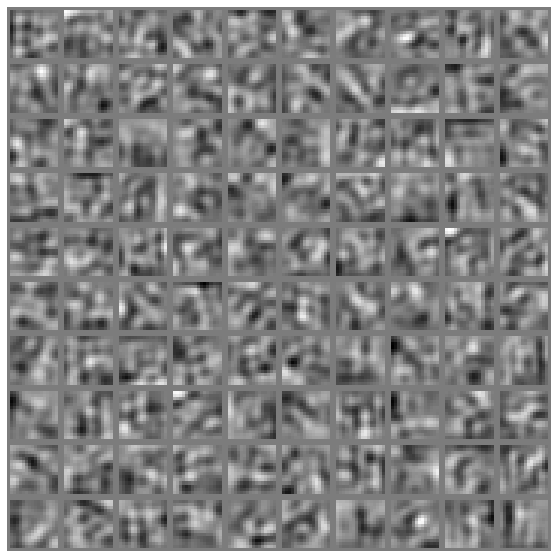

In [30]:
from scipy.stats import norm
from itertools import product

pad = 1

# x = vae_means[:nz*nz]
nz=int(np.sqrt(D0))
nz = 10
# x = kws.draw_mean(prior,obs, nz*nz).cpu().numpy()
x = clear_test_images[:nz*nz].cpu().numpy()
x -= x.mean(-1, keepdims=True)
x /= x.std(-1, keepdims=True)
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))

x = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0) ))
x = x.reshape(nz,nz,image_size+2*pad,image_size+2*pad,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
plt.figure(figsize=(10,10))

if nc == 1:
    x = x[...,0]


plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()